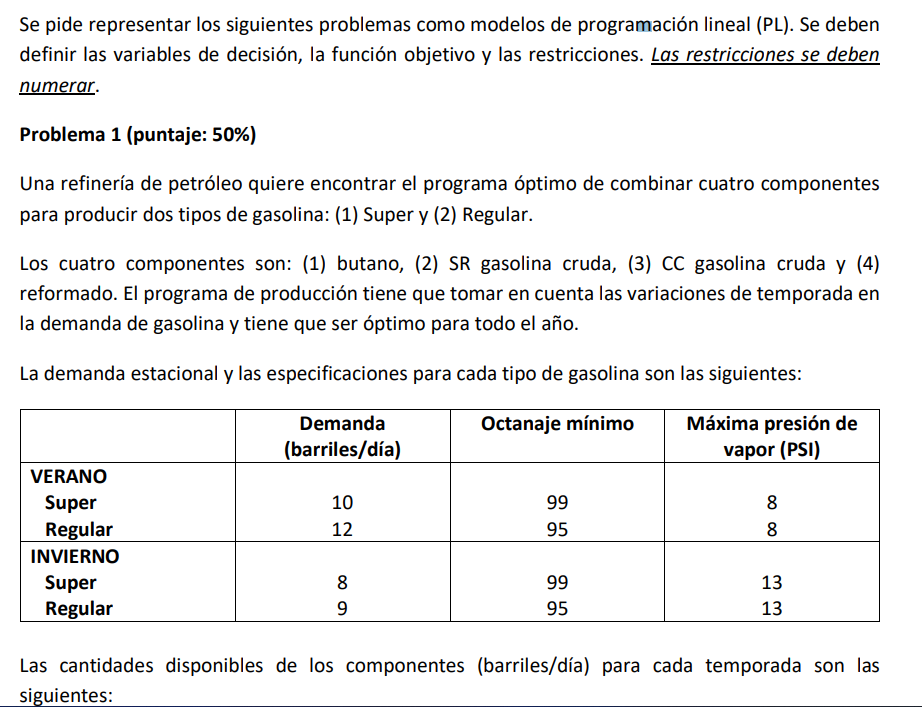

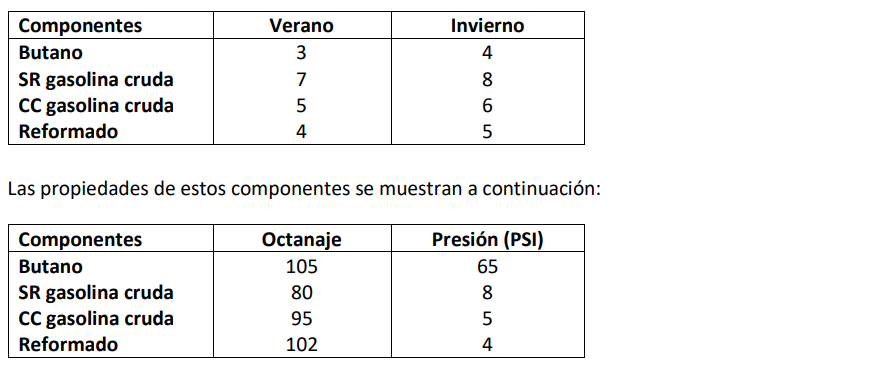

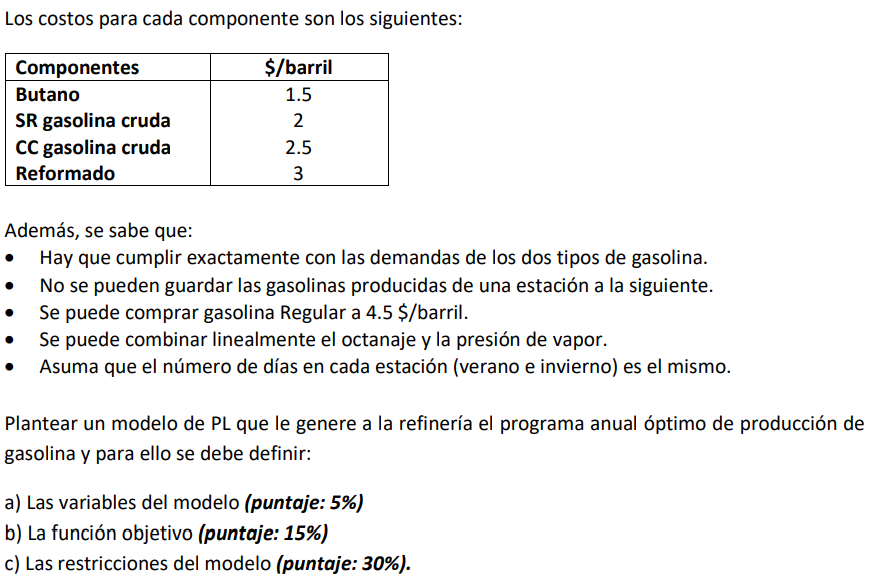

## Optimization model

#### Sets 
* $T$: Set of temporary stations, t $\in$ {Summer, Winter} 
* $I$: Set of oil components, i $\in$ {Butane, SR Crude, CC Crude, Reformed}
* $J$: Set of oil products, j $\in$ {Super, Regular}

#### Parameters
* $d_{j,t}$: Is the demand for oil product ${j}$ in the temporary station ${t}$, $\forall j \in J, \forall t \in T$
* $o_{j,t}$: Is the minimum octane content for oil product ${j}$ in the temporary station ${t}$, $\forall j \in J, \forall t \in T$
* $p_{j,t}$: Is the maximum pressure for oil product ${j}$ in the temporary station ${t}$, $\forall j \in J, \forall t \in T$
* $q_{i,t}$: Is the available quantity for oil component ${i}$ in the temporary station ${t}$, $\forall i \in I, \forall t \in T$
* $op_{i}$: Is the octane content for oil component ${i}$, $\forall i \in I$
* $pp_{i}$: Is the pressure content for oil component ${i}$, $\forall i \in I$
* $cost^{comp}_{i}$: Is the unit cost for oil component ${i}$, $\forall i \in I$
* $cost^{prod}_{j}$: Is the unit cost for oil product ${j}$, $\forall j \in J$

#### Decision variables
* $x_{i,j,t}$: Is the amount of barrels of oil component ${i}$ needed to produce the oil product ${j}$ in the temporary station ${t}$, $\forall i \in I, \forall j \in J, \forall t \in T$
* $y_{j,t}$: Is the amount of barrels of oil product ${j}$ produced to empty in the temporary station ${t}$, $\forall j \in J, \forall t \in T$

#### Objective function
$$\ Min\space \ Z = \sum_{i \in I} \sum_{j \in J} \sum_{t \in T} [cost^{comp}_{i} + cost^{prod}_{j}]*x_{i,j,t} $$

#### Constraints
Demand satisfaction
$$ \sum_{i \in I} x_{i,j,t} = d_{j,t}, \forall j \in J, \forall t \in T$$
Ocatane
$$ \sum_{i \in I} op_{i}*x_{i,j,t} \geq o_{j,t}, \forall j \in J, \forall t \in T$$
Pressure
$$ \sum_{i \in I} pp_{i}*x_{i,j,t} \leq p_{j,t}, \forall j \in J, \forall t \in T$$
Quantity available
$$ \sum_{j \in J} x_{i,j,t} \leq q_{i,t}, \forall i \in I, \forall t \in T$$
Empty produced oil product (check this constraint)
$$ x_{i,j,t+1} = x_{i,j,t} - y_{j,t}, \forall i \in I, \forall j \in J, t = 1 $$
$$ x_{i,j,t} = x_{i,j,t-1} - y_{j,t-1}, \forall i \in I, \forall j \in J, t = 2 $$
Non negative
$$ x_{i,j,t} \geq 0, \forall i \in I, \forall j \in J, \forall t \in T $$
$$ y_{j,t} \geq 0, \forall j \in J, \forall t \in T $$

## Code

In [1]:
import pyomo.environ as pe
import pyomo.opt as po

In [2]:
estaciones = {1,2}
componentes = {'Butane','SR crude', 'CC crude', 'Reformed'}
productos = {'Super', 'Regular'}
demanda = {(1,'Super'): 10, (1,'Regular'): 12,
           (2,'Super'): 8,  (2,'Regular'): 9}
OctMinimo = {(1,'Super'): 99, (1,'Regular'): 95,
             (2,'Super'): 99, (2,'Regular'): 95}
PresMaxima = {(1,'Super'): 8, (1,'Regular'): 8,
              (2,'Super'): 13, (2,'Regular'): 13}
disponible = {(1, 'Butane'): 3, (1, 'SR crude'): 7, (1, 'CC crude'): 5, (1, 'Reformed'): 4,
              (2, 'Butane'): 4, (2, 'SR crude'): 8, (2, 'CC crude'): 6, (2, 'Reformed'): 5}
octanaje = {'Butane': 105, 'SR crude': 80,'CC crude': 95,'Reformed': 102}
presion = {'Butane': 65, 'SR crude': 8,'CC crude': 5,'Reformed': 4}
costo_comp = {'Butane': 1.5, 'SR crude': 2,'CC crude': 2.5,'Reformed': 3}
costo_prod = {'Super': 0, 'Regular': 4.5}

In [3]:
#Sets
model = pe.ConcreteModel()
model.estaciones = pe.RangeSet(1,2)
model.componentes = pe.Set(initialize = componentes)
model.productos = pe.Set(initialize = productos)

    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    data source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


In [4]:
#Parameters
model.demanda = pe.Param(model.estaciones, model.productos, initialize = demanda)
model.OctMinimo = pe.Param(model.estaciones, model.productos, initialize = OctMinimo)
model.PresMaxima = pe.Param(model.estaciones, model.productos, initialize = PresMaxima)
model.disponible = pe.Param(model.estaciones, model.componentes, initialize = disponible)
model.octanaje = pe.Param(model.componentes, initialize = octanaje)
model.presion = pe.Param(model.componentes, initialize = presion)
model.costo_comp = pe.Param(model.componentes, initialize = costo_comp)
model.costo_prod = pe.Param(model.productos, initialize = costo_prod)

In [5]:
#Variables
model.x = pe.Var(model.componentes, model.productos, model.estaciones, domain = pe.NonNegativeReals)
model.y = pe.Var(model.productos, model.estaciones, domain = pe.NonNegativeReals)

In [6]:
#Objective function
def calculate_cost(model):
    cost = sum((model.costo_comp[i] + model.costo_prod[j]) * model.x[i,j,t] for i in model.componentes\
               for j in model.productos for t in model.estaciones)
    return cost
model.obj_function_cost = pe.Objective(sense = pe.minimize, rule = calculate_cost)

In [7]:
model.obj_function_cost.pprint()

obj_function_cost : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 6.5*x[SR crude,Regular,1] + 6.5*x[SR crude,Regular,2] + 2*x[SR crude,Super,1] + 2*x[SR crude,Super,2] + 7.0*x[CC crude,Regular,1] + 7.0*x[CC crude,Regular,2] + 2.5*x[CC crude,Super,1] + 2.5*x[CC crude,Super,2] + 7.5*x[Reformed,Regular,1] + 7.5*x[Reformed,Regular,2] + 3*x[Reformed,Super,1] + 3*x[Reformed,Super,2] + 6.0*x[Butane,Regular,1] + 6.0*x[Butane,Regular,2] + 1.5*x[Butane,Super,1] + 1.5*x[Butane,Super,2]


In [8]:
#Constraints
def demand(model, j, t):
    demand_left = sum(model.x[i,j,t] for i in model.componentes)
    demand_right = model.demanda[t,j]
    constraint = (demand_left == demand_right)
    return constraint
model.demand_constraint = pe.Constraint(model.productos, model.estaciones, rule = demand)

In [9]:
model.demand_constraint.pprint()

demand_constraint : Size=4, Index=demand_constraint_index, Active=True
    Key            : Lower : Body                                                                                        : Upper : Active
    ('Regular', 1) :  12.0 : x[SR crude,Regular,1] + x[CC crude,Regular,1] + x[Reformed,Regular,1] + x[Butane,Regular,1] :  12.0 :   True
    ('Regular', 2) :   9.0 : x[SR crude,Regular,2] + x[CC crude,Regular,2] + x[Reformed,Regular,2] + x[Butane,Regular,2] :   9.0 :   True
      ('Super', 1) :  10.0 :         x[SR crude,Super,1] + x[CC crude,Super,1] + x[Reformed,Super,1] + x[Butane,Super,1] :  10.0 :   True
      ('Super', 2) :   8.0 :         x[SR crude,Super,2] + x[CC crude,Super,2] + x[Reformed,Super,2] + x[Butane,Super,2] :   8.0 :   True


In [10]:
#Constraints
def octane(model, j, t):
    octane_left = sum(model.octanaje[i] * model.x[i,j,t] for i in model.componentes)
    octane_right = model.OctMinimo[t,j]
    constraint = (octane_left >= octane_right)
    return constraint
model.octane_constraint = pe.Constraint(model.productos, model.estaciones, rule = octane)

In [11]:
model.octane_constraint.pprint()

octane_constraint : Size=4, Index=octane_constraint_index, Active=True
    Key            : Lower : Body                                                                                                      : Upper : Active
    ('Regular', 1) :  95.0 : 80*x[SR crude,Regular,1] + 95*x[CC crude,Regular,1] + 102*x[Reformed,Regular,1] + 105*x[Butane,Regular,1] :  +Inf :   True
    ('Regular', 2) :  95.0 : 80*x[SR crude,Regular,2] + 95*x[CC crude,Regular,2] + 102*x[Reformed,Regular,2] + 105*x[Butane,Regular,2] :  +Inf :   True
      ('Super', 1) :  99.0 :         80*x[SR crude,Super,1] + 95*x[CC crude,Super,1] + 102*x[Reformed,Super,1] + 105*x[Butane,Super,1] :  +Inf :   True
      ('Super', 2) :  99.0 :         80*x[SR crude,Super,2] + 95*x[CC crude,Super,2] + 102*x[Reformed,Super,2] + 105*x[Butane,Super,2] :  +Inf :   True


In [12]:
#Constraints
def pressure(model, j, t):
    pressure_left = sum(model.presion[i] * model.x[i,j,t] for i in model.componentes)
    pressure_right = model.PresMaxima[t,j]
    constraint = (pressure_left <= pressure_right)
    return constraint
model.pressure_constraint = pe.Constraint(model.productos, model.estaciones, rule = pressure)

In [13]:
model.pressure_constraint.pprint()

pressure_constraint : Size=4, Index=pressure_constraint_index, Active=True
    Key            : Lower : Body                                                                                                 : Upper : Active
    ('Regular', 1) :  -Inf : 8*x[SR crude,Regular,1] + 5*x[CC crude,Regular,1] + 4*x[Reformed,Regular,1] + 65*x[Butane,Regular,1] :   8.0 :   True
    ('Regular', 2) :  -Inf : 8*x[SR crude,Regular,2] + 5*x[CC crude,Regular,2] + 4*x[Reformed,Regular,2] + 65*x[Butane,Regular,2] :  13.0 :   True
      ('Super', 1) :  -Inf :         8*x[SR crude,Super,1] + 5*x[CC crude,Super,1] + 4*x[Reformed,Super,1] + 65*x[Butane,Super,1] :   8.0 :   True
      ('Super', 2) :  -Inf :         8*x[SR crude,Super,2] + 5*x[CC crude,Super,2] + 4*x[Reformed,Super,2] + 65*x[Butane,Super,2] :  13.0 :   True


In [14]:
#Constraints
def quantity(model, i, t):
    quantity_left = sum(model.x[i,j,t] for j in model.productos)
    quantity_right = model.disponible[t,i]
    constraint = (quantity_left <= quantity_right)
    return constraint
model.quantity_constraint = pe.Constraint(model.componentes, model.estaciones, rule = quantity)

In [15]:
model.quantity_constraint.pprint()

quantity_constraint : Size=8, Index=quantity_constraint_index, Active=True
    Key             : Lower : Body                                        : Upper : Active
      ('Butane', 1) :  -Inf :     x[Butane,Regular,1] + x[Butane,Super,1] :   3.0 :   True
      ('Butane', 2) :  -Inf :     x[Butane,Regular,2] + x[Butane,Super,2] :   4.0 :   True
    ('CC crude', 1) :  -Inf : x[CC crude,Regular,1] + x[CC crude,Super,1] :   5.0 :   True
    ('CC crude', 2) :  -Inf : x[CC crude,Regular,2] + x[CC crude,Super,2] :   6.0 :   True
    ('Reformed', 1) :  -Inf : x[Reformed,Regular,1] + x[Reformed,Super,1] :   4.0 :   True
    ('Reformed', 2) :  -Inf : x[Reformed,Regular,2] + x[Reformed,Super,2] :   5.0 :   True
    ('SR crude', 1) :  -Inf : x[SR crude,Regular,1] + x[SR crude,Super,1] :   7.0 :   True
    ('SR crude', 2) :  -Inf : x[SR crude,Regular,2] + x[SR crude,Super,2] :   8.0 :   True


In [16]:
def inventory(model, i, j, t):
    if t == 1:
        inventory_left_summer = model.x[i,j,t+1]
        inventory_right_summer = model.x[i,j,t] - model.y[j,t]
        constraint = (inventory_left_summer == inventory_right_summer)
    elif t == 2:
        inventory_left_winter = model.x[i,j,t]
        inventory_right_winter = model.x[i,j,t-1] - model.y[j,t-1]
        constraint = (inventory_left_winter == inventory_right_winter)
    else:
        return pe.Constraint.Skip
    return constraint
model.inventory_constraint = pe.Constraint(model.componentes, model.productos, model.estaciones, rule = inventory)

In [17]:
model.inventory_constraint.pprint()

inventory_constraint : Size=16, Index=inventory_constraint_index, Active=True
    Key                        : Lower : Body                                                         : Upper : Active
      ('Butane', 'Regular', 1) :   0.0 :     x[Butane,Regular,2] - (x[Butane,Regular,1] - y[Regular]) :   0.0 :   True
      ('Butane', 'Regular', 2) :   0.0 :     x[Butane,Regular,2] - (x[Butane,Regular,1] - y[Regular]) :   0.0 :   True
        ('Butane', 'Super', 1) :   0.0 :           x[Butane,Super,2] - (x[Butane,Super,1] - y[Super]) :   0.0 :   True
        ('Butane', 'Super', 2) :   0.0 :           x[Butane,Super,2] - (x[Butane,Super,1] - y[Super]) :   0.0 :   True
    ('CC crude', 'Regular', 1) :   0.0 : x[CC crude,Regular,2] - (x[CC crude,Regular,1] - y[Regular]) :   0.0 :   True
    ('CC crude', 'Regular', 2) :   0.0 : x[CC crude,Regular,2] - (x[CC crude,Regular,1] - y[Regular]) :   0.0 :   True
      ('CC crude', 'Super', 1) :   0.0 :       x[CC crude,Super,2] - (x[CC crude,Super,1]

In [ ]:
#Infeasible solution, check the above constraint
solver = pe.SolverFactory('glpk')
result = solver.solve(model, tee=True)
pe.value(model.obj_function_cost)

In [ ]:
model.x.pprint()

In [ ]:
model.y.pprint()